In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
import tensorflow as tf
from datetime import datetime
import holidays
import math

C:\Users\vivs_\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\vivs_\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\vivs_\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
segment_speeds = read_csv("60_min_seg.csv", sep=";")
wind_speed = read_csv("wind.csv", sep=";")
rain = read_csv("rain.csv", sep=";")
snow_depth = read_csv("snow.csv", sep=";")
temperature = read_csv("temp.csv", sep=";")

In [3]:
rain.head()

,Datum,Tid (UTC),Nederbördsmängd,Kvalitet
0,1995-08-01,00:00:00,0.0,Y
1,1995-08-01,01:00:00,0.0,Y
2,1995-08-01,02:00:00,0.0,Y
3,1995-08-01,03:00:00,0.0,Y
4,1995-08-01,04:00:00,0.0,Y


In [4]:
wind_speed = wind_speed.loc[(wind_speed['Datum'] >= "2019-06-04")]
rain = rain.loc[(rain['Datum'] >= "2019-06-04")]
snow_depth = snow_depth.loc[(snow_depth['Datum'] >= "2019-06-04")]
temperature = temperature.loc[(temperature['Datum'] >= "2019-06-04")]

In [5]:
wind_speed.head(5)

,Datum,Tid (UTC),Vindriktning,Kvalitet,Vindhastighet,Kvalitet.1
297120,2019-06-04,00:00:00,192.0,G,4.7,G
297121,2019-06-04,01:00:00,204.0,G,5.0,G
297122,2019-06-04,02:00:00,211.0,G,4.8,G
297123,2019-06-04,03:00:00,214.0,G,4.9,G
297124,2019-06-04,04:00:00,231.0,G,6.7,G


Removing the first 24 records because the first 24 records are null values for traffic speed

In [6]:
segment_speeds = segment_speeds[24:]

Adding days and hours to the dataset because that could make it easier for it to identify what time instead of receiving a date column which is more complex.

In [7]:
pd.to_datetime(segment_speeds['StartTime'], format="%Y-%m-%d %H:%M:%S")
segment_speeds['hour'] = pd.DatetimeIndex(segment_speeds['StartTime']).hour
segment_speeds['day'] = pd.DatetimeIndex(segment_speeds['StartTime']).dayofyear
segment_speeds['year'] = pd.DatetimeIndex(segment_speeds['StartTime']).year
segment_speeds['day_name'] = pd.DatetimeIndex(segment_speeds['StartTime']).day_name()

In [8]:
dummy1 = pd.get_dummies(segment_speeds['day_name'])

In [9]:
segment_speeds = pd.concat([segment_speeds, dummy1], axis=1).drop('day_name', axis=1)

Adding holidays

In [10]:
sweden_holidays = holidays.country_holidays('SE')

In [11]:
holiday = []
 
for date in segment_speeds[['StartTime']].values:
    
    year_month_day = date[0].split(' ')[0]
    
    res = sweden_holidays.get(str(year_month_day))
    
    if res != None and res != "Söndag":
        holiday.append(1)
    else:
        holiday.append(0)

segment_speeds['holiday'] = holiday

Interpolation is performed for null values

In [12]:
segment_speeds = segment_speeds.interpolate(method='linear', limit_direction='forward', axis=0)


Now we merge the traffic speeds with the weather data and first need to put the segment speeds in same format as the weather data

In [13]:
pd.to_datetime(temperature['Datum'], format="%Y-%m-%d")
pd.to_datetime(temperature['Tid (UTC)'], format="%H:%M:%S")
temperature['hour'] = pd.DatetimeIndex(temperature['Tid (UTC)']).hour
temperature['day'] = pd.DatetimeIndex(temperature['Datum']).dayofyear
temperature['year'] = pd.DatetimeIndex(temperature['Datum']).year

pd.to_datetime(rain['Datum'], format="%Y-%m-%d")
pd.to_datetime(rain['Tid (UTC)'], format="%H:%M:%S")
rain['hour'] = pd.DatetimeIndex(rain['Tid (UTC)']).hour
rain['day'] = pd.DatetimeIndex(rain['Datum']).dayofyear
rain['year'] = pd.DatetimeIndex(rain['Datum']).year

pd.to_datetime(wind_speed['Datum'], format="%Y-%m-%d")
pd.to_datetime(wind_speed['Tid (UTC)'], format="%H:%M:%S")
wind_speed['hour'] = pd.DatetimeIndex(wind_speed['Tid (UTC)']).hour
wind_speed['day'] = pd.DatetimeIndex(wind_speed['Datum']).dayofyear
wind_speed['year'] = pd.DatetimeIndex(wind_speed['Datum']).year

pd.to_datetime(snow_depth['Datum'], format="%Y-%m-%d")
pd.to_datetime(snow_depth['Tid (UTC)'], format="%H:%M:%S")
snow_depth['hour'] = pd.DatetimeIndex(snow_depth['Tid (UTC)']).hour
snow_depth['day'] = pd.DatetimeIndex(snow_depth['Datum']).dayofyear
snow_depth['year'] = pd.DatetimeIndex(snow_depth['Datum']).year


A left join is done to keep the values from the old data because for example snow_depth only have records certain days and then we could fill the NaN values from the left join with some approximation

In [14]:
#segment_speeds_weather = segment_speeds[['SegmentId', 'hour', 'day', 'year', 'Speed']]
segment_speeds_weather = segment_speeds

segment_speeds_weather = pd.merge(segment_speeds[['SegmentId', 'hour', 'day', 'year', 'Speed', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'Friday', 'holiday']], temperature[['Lufttemperatur', 'hour', 'day', 'year']], on=['day', 'year', 'hour'], how='left')
segment_speeds_weather = pd.merge(segment_speeds_weather, rain[['Nederbördsmängd', 'hour', 'day', 'year']], on=['day', 'year', 'hour'], how='left')
segment_speeds_weather = pd.merge(segment_speeds_weather, wind_speed[['Vindhastighet', 'hour', 'day', 'year']], on=['day', 'year', 'hour'], how='left')
segment_speeds_weather = pd.merge(segment_speeds_weather, snow_depth[['Snödjup', 'hour', 'day', 'year']], on=['day', 'year'], how='left')
segment_speeds_weather.rename(columns = {'hour_x':'hour'}, inplace = True)
segment_speeds_weather.drop('hour_y', axis=1, inplace=True)

Adding temperature based on last known temperature when missing data

In [15]:
temp = []

last_known_temperatuer = None
for temperature in segment_speeds_weather[['Lufttemperatur']].values:


    #print(temperature[0], type(temperature[0]))
    if math.isnan(temperature[0]):
        
        if last_known_temperatuer == None:
            print("The first NaN values has no previous value to put there")
        else:
            temp.append(last_known_temperatuer)
    else:
        last_known_temperatuer = temperature[0]
        temp.append(temperature[0])
        

segment_speeds_weather['Temperature-with-last-known-value-on-nan'] = temp

Adding AVG wind speed for NaN Values

In [16]:
avg_wind_speed = segment_speeds_weather['Vindhastighet'].mean()


wind_speeds = []

for wind_speed in segment_speeds_weather[['Vindhastighet']].values:
    
    if math.isnan(wind_speed[0]):
        wind_speeds.append(avg_wind_speed)
    else:
        wind_speeds.append(wind_speed[0])
        

segment_speeds_weather['Wind-speed-avg-when-nan'] = wind_speeds

Handle NAN values

In [17]:
segment_speeds_weather['Lufttemperatur'] = segment_speeds_weather['Lufttemperatur'].interpolate(method='linear', limit_direction='forward', axis=0)
segment_speeds_weather['Nederbördsmängd'] = segment_speeds_weather['Nederbördsmängd'].interpolate(method='linear', limit_direction='forward', axis=0)
segment_speeds_weather['Vindhastighet'] = segment_speeds_weather['Vindhastighet'].interpolate(method='linear', limit_direction='forward', axis=0)
segment_speeds_weather['Snödjup'] = segment_speeds_weather['Snödjup'].fillna(0)

In [18]:
segment_speeds_weather.isna().sum()

SegmentId                                   0
hour                                        0
day                                         0
year                                        0
Speed                                       0
Monday                                      0
Saturday                                    0
Sunday                                      0
Thursday                                    0
Tuesday                                     0
Wednesday                                   0
Friday                                      0
holiday                                     0
Lufttemperatur                              0
Nederbördsmängd                             0
Vindhastighet                               0
Snödjup                                     0
Temperature-with-last-known-value-on-nan    0
Wind-speed-avg-when-nan                     0
dtype: int64

Make it into CSV for us to use

In [19]:
segment_speeds_weather.to_csv("segment_speeds_weather.csv", sep=",")

In [20]:
segment_speeds_weather.head(5)

,SegmentId,hour,day,year,Speed,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Friday,holiday,Lufttemperatur,Nederbördsmängd,Vindhastighet,Snödjup,Temperature-with-last-known-value-on-nan,Wind-speed-avg-when-nan
0,226255131,0,155,2019,91.383333,0,0,0,0,1,0,0,0,13.7,0.0,4.7,0.0,13.7,4.7
1,226255131,1,155,2019,92.000000,0,0,0,0,1,0,0,0,14.1,0.0,5.0,0.0,14.1,5.0
2,226255131,2,155,2019,93.666667,0,0,0,0,1,0,0,0,14.2,0.0,4.8,0.0,14.2,4.8
3,226255131,3,155,2019,86.216667,0,0,0,0,1,0,0,0,14.3,0.0,4.9,0.0,14.3,4.9
4,226255131,4,155,2019,90.116667,0,0,0,0,1,0,0,0,13.6,0.0,6.7,0.0,13.6,6.7


In [21]:
dataset=segment_speeds_weather
values = dataset.values
# ensure all data is float
values = values.astype('float32')

In [29]:
# normalizing input features
scaler = MinMaxScaler(feature_range=(1, 10))
scaled = scaler.fit_transform(values)
scaled =pd.DataFrame(scaled)
scaled.head(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.0,1.000000,4.79726,1.0,6.953828,1.0,1.0,1.0,1.0,10.0,1.0,1.0,1.0,6.600,1.0,3.136364,1.0,6.600,3.136364
1,0.0,1.391304,4.79726,1.0,6.997262,1.0,1.0,1.0,1.0,10.0,1.0,1.0,1.0,6.700,1.0,3.272727,1.0,6.700,3.272727
2,0.0,1.782609,4.79726,1.0,7.114647,1.0,1.0,1.0,1.0,10.0,1.0,1.0,1.0,6.725,1.0,3.181818,1.0,6.725,3.181818
3,0.0,2.173913,4.79726,1.0,6.589931,1.0,1.0,1.0,1.0,10.0,1.0,1.0,1.0,6.750,1.0,3.227273,1.0,6.750,3.227273


In [24]:
def create_ts_data(dataset, lookback=1, predicted_col=2):
    temp=dataset.copy()
    temp["id"]= range(1, len(temp)+1)
    temp = temp.iloc[:-lookback, :]
    temp.set_index('id', inplace =True)
    predicted_value=dataset.copy()
    predicted_value = predicted_value.iloc[lookback:,predicted_col]
    predicted_value.columns=["Predcited"]
    predicted_value= pd.DataFrame(predicted_value)
    
    predicted_value["id"]= range(1, len(predicted_value)+1)
    predicted_value.set_index('id', inplace =True)
    final_df= pd.concat([temp, predicted_value], axis=1)
    #final_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)','var1(t)']
    #final_df.set_index('Date', inplace=True)
    return final_df

In [43]:
#We now create the time series dataset with looking back one time step

reframed_df= create_ts_data(scaled, 10,18)
reframed_df.fillna(0, inplace=True)

reframed_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)','var5(t-1)', 'var6(t-1)', 'var7(t-1)','var8(t-1)','var9(t-1)','var10(t-1)','var11(t-1)','var12(t-1)','var13(t-1)','var14(t-1)','var15(t-1)','var16(t-1)','var17(t-1)','var18(t-1)','var19(t-1)','var1(t)',]
print(reframed_df.head(4))

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
id                                                                     
1         0.0   1.000000    4.79726        1.0   6.953828        1.0   
2         0.0   1.391304    4.79726        1.0   6.997262        1.0   
3         0.0   1.782609    4.79726        1.0   7.114647        1.0   
4         0.0   2.173913    4.79726        1.0   6.589931        1.0   

    var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
id                                                                        
1         1.0        1.0        1.0        10.0         1.0         1.0   
2         1.0        1.0        1.0        10.0         1.0         1.0   
3         1.0        1.0        1.0        10.0         1.0         1.0   
4         1.0        1.0        1.0        10.0         1.0         1.0   

    var13(t-1)  var14(t-1)  var15(t-1)  var16(t-1)  var17(t-1)  var18(t-1)  \
id                                    

In [44]:
# split into train and test sets
values = reframed_df.values
training_sample =int( len(dataset) *0.75)
train = values[:training_sample, :]
test = values[training_sample:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [45]:
# reshape input to be 3D [samples, time steps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(16164, 1, 19) (16164,) (5378, 1, 19) (5378,)


In [46]:
model_lstm = Sequential()
model_lstm.add(LSTM(384, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm.add(LSTM(units=70, return_sequences=True))
model_lstm.add(LSTM(units=70))
model_lstm.add(Dense(units=1))

model_lstm.compile(loss='mae', optimizer='adam')
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 384)            620544    
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 70)             127400    
_________________________________________________________________
lstm_5 (LSTM)                (None, 70)                39480     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 71        
Total params: 787,495
Trainable params: 787,495
Non-trainable params: 0
_________________________________________________________________


In [54]:
# fit network
lstm_history = model_lstm.fit(train_X, train_y, epochs=120,validation_data=(test_X, test_y), batch_size=64, shuffle=False)

Epoch 1/120
253/253 [==============================] - 2s 7ms/step - loss: 0.6936 - val_loss: 0.9862
Epoch 2/120
253/253 [==============================] - 2s 7ms/step - loss: 0.6918 - val_loss: 0.9891
Epoch 3/120
253/253 [==============================] - 2s 7ms/step - loss: 0.6851 - val_loss: 0.9899
Epoch 4/120
253/253 [==============================] - 2s 8ms/step - loss: 0.6864 - val_loss: 0.9932
Epoch 5/120
253/253 [==============================] - 2s 9ms/step - loss: 0.6825 - val_loss: 0.9904
Epoch 6/120
253/253 [==============================] - 2s 9ms/step - loss: 0.6814 - val_loss: 0.9932
Epoch 7/120
253/253 [==============================] - 2s 9ms/step - loss: 0.6789 - val_loss: 0.9930
Epoch 8/120
253/253 [==============================] - 2s 10ms/step - loss: 0.6760 - val_loss: 0.9975
Epoch 9/120
253/253 [==============================] - 2s 10ms/step - loss: 0.6715 - val_loss: 0.9973
Epoch 10/120
253/253 [==============================] - 2s 10ms/step - loss: 0.6732 - val

Epoch 81/120
253/253 [==============================] - 2s 10ms/step - loss: 0.5477 - val_loss: 1.0541
Epoch 82/120
253/253 [==============================] - 3s 10ms/step - loss: 0.5466 - val_loss: 1.0694
Epoch 83/120
253/253 [==============================] - 3s 11ms/step - loss: 0.5430 - val_loss: 1.0595
Epoch 84/120
253/253 [==============================] - 3s 10ms/step - loss: 0.5450 - val_loss: 1.0698
Epoch 85/120
253/253 [==============================] - 3s 10ms/step - loss: 0.5392 - val_loss: 1.0668
Epoch 86/120
253/253 [==============================] - 3s 10ms/step - loss: 0.5378 - val_loss: 1.0699
Epoch 87/120
253/253 [==============================] - 3s 10ms/step - loss: 0.5365 - val_loss: 1.0701
Epoch 88/120
253/253 [==============================] - 3s 10ms/step - loss: 0.5328 - val_loss: 1.0718
Epoch 89/120
253/253 [==============================] - 3s 11ms/step - loss: 0.5305 - val_loss: 1.0729
Epoch 90/120
253/253 [==============================] - 3s 10ms/step - lo

In [55]:
pred_y =  model_lstm.predict(test_X)

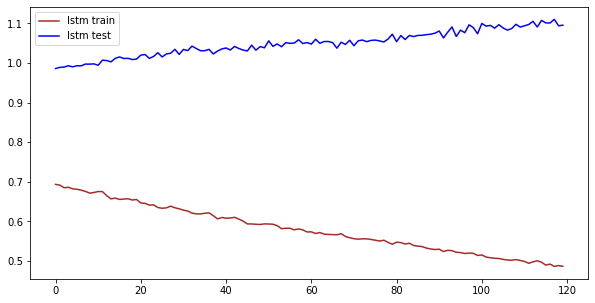

In [56]:
pyplot.plot(lstm_history.history['loss'], label='lstm train', color='brown')
pyplot.plot(lstm_history.history['val_loss'], label='lstm test', color='blue')
pyplot.legend()
pyplot.show()

In [57]:
test_y.reshape(5378,1)

array([[2.409091 ],
       [2.8636365],
       [3.1363635],
       ...,
       [4.6818185],
       [7.2727275],
       [5.7272725]], dtype=float32)

In [58]:
pred_y

array([[1.8225976],
       [1.9691688],
       [2.2509444],
       ...,
       [4.3579516],
       [4.3486376],
       [4.1836486]], dtype=float32)

1.9658366
-0.12738712261081941
1.4020829662229937
1.0956407


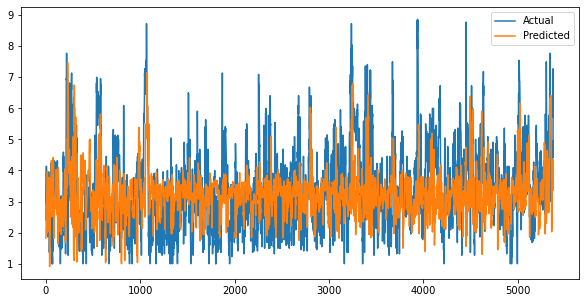

In [59]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,5)

from sklearn.metrics import *
from math import sqrt

MSE = mean_squared_error(test_y, pred_y)
R2 = r2_score(test_y, pred_y)
RMSE = sqrt(mean_squared_error(test_y, pred_y))
MAE = mean_absolute_error(test_y, pred_y)


print(MSE)
print(R2)
print(RMSE)
print(MAE)

#plotting predicted test value vs actual test value
plt.plot(test_y, label = 'Actual')
plt.plot(pred_y, label = 'Predicted')
plt.legend()
plt.show()

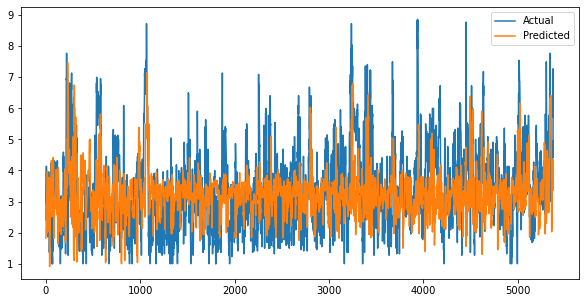

In [60]:
#visualization over full data
tra = test_X
tes = test_y
fp = model_lstm.predict(tra)
plt.plot(tes, label = 'Actual')
plt.plot(fp, label = 'Predicted')
plt.legend()
plt.show()

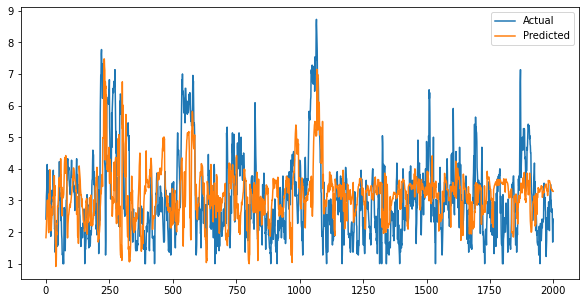

In [61]:
#over small part of data
plt.plot(tes[:2000], label = 'Actual')
plt.plot(fp[:2000], label = 'Predicted')
plt.legend()
plt.show()